# QUELLE ÉVOLUTION DE L'ACTIVITÉ CES 30 DERNIERS JOURS ?

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt,timedelta
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from kiblib.utils.db import DbConn
#import warnings
#warnings.filterwarnings("ignore")

In [2]:
maj = dt.today().strftime('%d-%m-%Y')
maj_heure = dt.today().strftime('%Hh%M et %Ssecondes')
print(f"Dernière mise à jour le {maj} à {maj_heure}")

Dernière mise à jour le 06-11-2024 à 12h06 et 03secondes


In [3]:
db_conn = DbConn().create_engine()

In [4]:
#DEFINITION DES VARIABLES A UTILISER PAR LA SUITE
annee = pd.to_datetime("today").year
semaine_max = pd.to_datetime("today").week
semaine_min = semaine_max - 5 
JourDeLaSemaine = "AS 'jour'"

In [5]:
# On définit une varitable x qui contient le jour de la semaine (ex : lundi = 1, mardi = 2, etc...)
x = date.today().isocalendar()[2]
# On définit une variable fin_cal qui est la date d'aujourd'hui moins x, le jour auquel on exécute le notebook
fin_cal = date.today() - timedelta(days=x)
# On définit une variable debut_cal qui est la fin_cal moins 27 jours, soit les 4 dernières semaines
debut_cal = fin_cal - timedelta(days=27)
# On génère une liste des dates entre la date de début et la date de fin
calendrier_index = pd.date_range(start=debut_cal, end=fin_cal)
# On transforme la liste en un dataframe contenant l'info sur le jour
calendrier = calendrier_index.to_frame(index=False, name='jour')
# On convertie ensuite les valeurs du calendrier jour au format date
calendrier['jour'] = pd.DatetimeIndex(calendrier['jour']).date
#Conversion au format datetime64
calendrier['jour'] = calendrier['jour'].astype("datetime64")

In [6]:
# On définit la variable query comme un string contenant une requête SQL pour obtenir les entrées de l'année en cours
query = f"SELECT datetime AS 'jour', entrees AS nombre_entrees FROM statdb.stat_entrees WHERE YEAR(`datetime`) = {annee}"
# On créer un dataframe à partir de la requête SQL
entrees = pd.read_sql(query,db_conn)

In [7]:
# ENTREES

# On définit la variable query comme un string contenant une requête SQL pour obtenir les entrées de l'année en cours
query = f"SELECT datetime AS 'jour', entrees AS nombre_entrees FROM statdb.stat_entrees WHERE YEAR(`datetime`) = {annee}"
# On créer un dataframe à partir de la requête SQL
entrees = pd.read_sql(query,db_conn)
#Nettoyage des données comprise avant 14h le dimanche
entrees.loc[(entrees['jour'].dt.day_of_week==6) &
            (entrees['jour'].dt.hour<14),['data_avant_14h']] = True

entrees = entrees[entrees['data_avant_14h']!=True]
# On convertie la colonne jour au format date
entrees["jour"] = entrees["jour"].dt.date
# On crée une colonne contenant le numéro de semaine, à partir de la colonne jour
entrees['jour'] = pd.to_datetime(entrees['jour'])
entrees['semaine'] = entrees['jour'].dt.isocalendar().week
# On filtre notre dataframe en ne gardant que les données contenues entre la semaine_min et la semaine_max
entrees_4lastweek = entrees[entrees["semaine"].between(semaine_min,semaine_max)]
# On crée un array qui contient le nombre d'entrées totales par jour
entrees_4lastweek = entrees_4lastweek.groupby("jour")["nombre_entrees"].sum()
# On le retransforme en un dataframe
entrees_4lastweek = entrees_4lastweek.reset_index()
# On fusionne le dataframe et le calendrier définit plus haut pour ne garder que les lignes du calendrier
entrees_4lastweek = entrees_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')
# On recrée un dataframe et on y ajoute des colonnes contenant le nom du jour, le numéro du jour et le mois
entrees_4lastweek["jour"] = pd.DatetimeIndex(entrees_4lastweek["jour"])
entrees_4lastweek["jour_str"] = pd.DatetimeIndex(entrees_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
entrees_4lastweek["jour_num"] = pd.DatetimeIndex(entrees_4lastweek["jour"]).day
entrees_4lastweek["mois"] = pd.DatetimeIndex(entrees_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
# On crée une dernière colonne qui regroupe toutes les informations ci-dessus
entrees_4lastweek["date"] = entrees_4lastweek["jour_str"] + ' ' + entrees_4lastweek["jour_num"].astype(str) + ' ' + entrees_4lastweek["mois"]
# On créer une colonne jour ouvert
# Si le nombre d'entrées est supérieur à 0, on compte 1 
entrees_4lastweek.loc[entrees_4lastweek['nombre_entrees']>0,['jour ouvert']] = 1
# Si le nombre le jour correspond à dimanche et que le nombre d'entrée est supérieur à 0 on enlève 0.5
entrees_4lastweek.loc[(entrees_4lastweek["jour_str"]=="Dimanche") & 
                      (entrees_4lastweek["nombre_entrees"]>0),["jour ouvert"]] = entrees_4lastweek["jour ouvert"]-0.5
# On fait le total des jours ouvert pour les entrées
nb_jours_ouverts = entrees_4lastweek['jour ouvert'].sum()
# On fait le total des entrées des 4 dernières semaine puis on les convertie en (int)
total_entrees = entrees_4lastweek["nombre_entrees"].sum().astype(int)
# On fait la moyenne des entrées sur les 4 dernières semaines
mean_entrees = (total_entrees / nb_jours_ouverts).round(0).astype(int)

In [8]:
# CONNEXIONS ORDIS

query = f"SELECT heure_deb AS 'jour',borrowernumber FROM statdb.stat_webkiosk WHERE YEAR(heure_deb) = {annee}"
ordis = pd.read_sql(query,db_conn)
ordis['nombre_connexions'] = 1
ordis['jour'] = pd.DatetimeIndex(ordis['jour']).date
ordis['jour'] = pd.to_datetime(ordis['jour'])
ordis['semaine'] = ordis['jour'].dt.isocalendar().week
ordis_4lastweek = ordis[ordis["semaine"].between(semaine_min,semaine_max)]
ordis_4lastweek = ordis_4lastweek.groupby("jour")["nombre_connexions"].sum()
ordis_4lastweek = ordis_4lastweek.reset_index()
ordis_4lastweek['type'] = 'ordinateur'
ordis_4lastweek = ordis_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')
ordis_4lastweek["jour"] = pd.DatetimeIndex(ordis_4lastweek["jour"])
ordis_4lastweek["jour_str"] = pd.DatetimeIndex(ordis_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
ordis_4lastweek["jour_num"] = pd.DatetimeIndex(ordis_4lastweek["jour"]).day
ordis_4lastweek["mois"] = pd.DatetimeIndex(ordis_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
ordis_4lastweek["date"] = ordis_4lastweek["jour_str"] + ' ' + ordis_4lastweek["jour_num"].astype(str) + ' ' + ordis_4lastweek["mois"]

total_ordis = ordis_4lastweek["nombre_connexions"].sum().astype(int)
mean_ordis = (total_ordis/nb_jours_ouverts).round(0).astype(int)
query = f"SELECT heure_deb AS 'jour',borrowernumber FROM statdb.stat_webkiosk WHERE YEAR(heure_deb) = {annee}"
distinct_ordis = pd.read_sql(query,db_conn)
distinct_ordis['nombre_connexions'] = 1
distinct_ordis['jour'] = pd.DatetimeIndex(distinct_ordis['jour']).date
#distinct_ordis['semaine'] = pd.DatetimeIndex(distinct_ordis['jour']).week
distinct_ordis['jour'] = pd.to_datetime(distinct_ordis['jour'])
distinct_ordis['semaine'] = distinct_ordis['jour'].dt.isocalendar().week
distinct_ordis = distinct_ordis[distinct_ordis["semaine"].between(semaine_min,semaine_max)]
distinct_ordis = distinct_ordis.groupby("nombre_connexions")["borrowernumber"].nunique().sum()
ordis_4lastweek["type"] = 'ordinateurs'

In [9]:
# CONNEXIONS WIFI

query = f"SELECT start_wifi AS 'jour'FROM statdb.stat_wifi WHERE YEAR(start_wifi) = {annee}"
wifi = pd.read_sql(query,db_conn)
wifi["nombre_connexions"] = 1
wifi['jour'] = pd.DatetimeIndex(wifi['jour']).date
wifi['jour'] = pd.to_datetime(wifi['jour'])
wifi['semaine'] = wifi['jour'].dt.isocalendar().week
wifi_4lastweek = wifi[wifi["semaine"].between(semaine_min,semaine_max)]
wifi_4lastweek = wifi_4lastweek.groupby("jour")["nombre_connexions"].sum()
wifi_4lastweek = wifi_4lastweek.reset_index()
wifi_4lastweek["type"] = "wifi"
wifi_4lastweek = wifi_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')
wifi_4lastweek["jour"] = pd.DatetimeIndex(wifi_4lastweek["jour"])
wifi_4lastweek["jour_str"] = pd.DatetimeIndex(wifi_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
wifi_4lastweek["jour_num"] = pd.DatetimeIndex(wifi_4lastweek["jour"]).day
wifi_4lastweek["mois"] = pd.DatetimeIndex(wifi_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
wifi_4lastweek["date"] = wifi_4lastweek["jour_str"] + ' ' + wifi_4lastweek["jour_num"].astype(str) + ' ' + wifi_4lastweek["mois"]

total_wifi = wifi_4lastweek["nombre_connexions"].sum().astype(int)
mean_wifi = (total_wifi/nb_jours_ouverts).round(0).astype(int)
query = f"SELECT start_wifi AS 'jour',borrowernumber FROM statdb.stat_wifi WHERE YEAR(start_wifi) = {annee}"
distinct_wifi = pd.read_sql(query,db_conn)
distinct_wifi['nombre_connexions'] = 1
distinct_wifi['jour'] = pd.DatetimeIndex(distinct_wifi['jour']).date
#distinct_wifi['semaine'] = pd.DatetimeIndex(distinct_wifi['jour']).week
distinct_wifi['jour'] = pd.to_datetime(distinct_wifi['jour'])
distinct_wifi['semaine'] = distinct_wifi['jour'].dt.isocalendar().week
distinct_wifi = distinct_wifi[distinct_wifi["semaine"].between(semaine_min,semaine_max)]
distinct_wifi = distinct_wifi.groupby("nombre_connexions")["borrowernumber"].nunique().sum()

In [10]:
# PRETS

query = f"SELECT pret_date_pret AS 'jour' FROM statdb.stat_prets sp WHERE YEAR(pret_date_pret) ={annee}"
prets = pd.read_sql(query,db_conn)
prets["nombre_emprunts"] = 1
prets['jour'] = prets['jour'].dt.date
prets['jour'] = pd.to_datetime(prets['jour'])
prets['semaine'] = prets['jour'].dt.isocalendar().week
prets_4lastweek = prets[prets['semaine'].between(semaine_min,semaine_max)]
prets_4lastweek = prets_4lastweek.groupby("jour")["nombre_emprunts"].sum()
prets_4lastweek = prets_4lastweek.reset_index()
prets_4lastweek = prets_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')
prets_4lastweek["jour"] = pd.DatetimeIndex(prets_4lastweek["jour"])
prets_4lastweek["jour_str"] = pd.DatetimeIndex(prets_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
prets_4lastweek["jour_num"] = pd.DatetimeIndex(prets_4lastweek["jour"]).day
prets_4lastweek["mois"] = pd.DatetimeIndex(prets_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
prets_4lastweek["date"] = prets_4lastweek["jour_str"] + ' ' + prets_4lastweek["jour_num"].astype(str) + ' ' + prets_4lastweek["mois"]

total_prets = prets_4lastweek["nombre_emprunts"].sum().astype(int)
mean_prets = (total_prets/nb_jours_ouverts).round(0).astype(int)
query = f"SELECT issuedate AS 'jour',borrowernumber FROM statdb.stat_issues si WHERE YEAR(issuedate) = {annee}"
distinct_prets = pd.read_sql(query,db_conn)
distinct_prets['nombre_prets'] = 1
distinct_prets['jour'] = pd.DatetimeIndex(distinct_prets['jour']).date
#distinct_prets['semaine'] = pd.DatetimeIndex(distinct_prets['jour']).week
distinct_prets['jour'] = pd.to_datetime(distinct_prets['jour'])
distinct_prets['semaine'] = distinct_prets['jour'].dt.isocalendar().week
distinct_prets = distinct_prets[distinct_prets["semaine"].between(semaine_min,semaine_max)]
distinct_prets = distinct_prets.groupby("nombre_prets")["borrowernumber"].nunique().sum()

In [11]:
# RETOURS

query = f"SELECT pret_date_retour_effectif AS 'jour' FROM statdb.stat_prets sp WHERE YEAR(pret_date_pret) = {annee}"
retours = pd.read_sql(query,db_conn)
retours["nombre_retours"] = 1
retours['jour'] = retours['jour'].dt.date
#retours["semaine"] = pd.DatetimeIndex(retours["jour"]).week
retours['jour'] = pd.to_datetime(retours['jour'])
retours['semaine'] = retours['jour'].dt.isocalendar().week
retours = retours[retours["semaine"].between(semaine_min,semaine_max)]
retours_4lastweek = retours.groupby("jour")["nombre_retours"].sum()
retours_4lastweek = retours_4lastweek.reset_index()
retours_4lastweek = retours_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')
retours_4lastweek["jour"] = pd.DatetimeIndex(retours_4lastweek["jour"])
retours_4lastweek["jour_str"] = pd.DatetimeIndex(retours_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
retours_4lastweek["jour_num"] = pd.DatetimeIndex(retours_4lastweek["jour"]).day
retours_4lastweek["mois"] = pd.DatetimeIndex(retours_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
retours_4lastweek["date"] = retours_4lastweek["jour_str"] + ' ' + retours_4lastweek["jour_num"].astype(str) + ' ' + retours_4lastweek["mois"]

total_retours = retours_4lastweek["nombre_retours"].sum().astype(int)
mean_retours = (total_retours/28).round(0).astype(int)

In [12]:
# RESAS

query = f"SELECT reservedate AS 'jour' FROM statdb.stat_reserves sr WHERE YEAR(reservedate) = {annee}"
reservations = pd.read_sql(query,db_conn)
reservations['nombre_reservations'] = 1
reservations['jour'] = pd.DatetimeIndex(reservations['jour']).date
reservations['jour'] = pd.to_datetime(reservations['jour'])
reservations['semaine'] = reservations['jour'].dt.isocalendar().week
reservations_4lastweek = reservations[reservations["semaine"].between(semaine_min,semaine_max)]
reservations_4lastweek = reservations_4lastweek.groupby("jour")["nombre_reservations"].sum()
reservations_4lastweek = reservations_4lastweek.reset_index()
reservations_4lastweek = reservations_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')
reservations_4lastweek["jour"] = pd.DatetimeIndex(reservations_4lastweek["jour"])
reservations_4lastweek["jour_str"] = pd.DatetimeIndex(reservations_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
reservations_4lastweek["jour_num"] = pd.DatetimeIndex(reservations_4lastweek["jour"]).day
reservations_4lastweek["mois"] = pd.DatetimeIndex(reservations_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
reservations_4lastweek["date"] = reservations_4lastweek["jour_str"] + ' ' + reservations_4lastweek["jour_num"].astype(str) + ' ' + reservations_4lastweek["mois"]

total_reservations = reservations_4lastweek["nombre_reservations"].sum().astype(int)
mean_reservations = (total_reservations/28).round(0).astype(int)
query = f"SELECT reservedate AS 'jour',borrowernumber FROM statdb.stat_reserves sr WHERE YEAR(reservedate) = {annee}"
distinct_resas = pd.read_sql(query,db_conn)
distinct_resas['nombre_resas'] = 1
distinct_resas['jour'] = pd.DatetimeIndex(distinct_resas['jour']).date
#distinct_resas['semaine'] = pd.DatetimeIndex(distinct_resas['jour']).week
distinct_resas['jour'] = pd.to_datetime(distinct_resas['jour'])
distinct_resas['semaine'] = distinct_resas['jour'].dt.isocalendar().week
distinct_resas = distinct_resas[distinct_resas["semaine"].between(semaine_min,semaine_max)]
distinct_resas = distinct_resas.groupby("nombre_resas")["borrowernumber"].nunique().sum()

In [13]:
# IMPRESSIONS 

query = f"SELECT date_impression AS 'jour',utilisateur,nb_pages_imprimees,type_impression FROM statdb.stat_impressions WHERE YEAR(date_impression) = {annee}"
impressions = pd.read_sql(query,db_conn)
impressions['jour'] = pd.DatetimeIndex(impressions['jour']).date
impressions['jour'] = pd.to_datetime(impressions['jour'])
impressions['semaine'] = impressions['jour'].dt.isocalendar().week

impressions_4lastweek = impressions[impressions["semaine"].between(semaine_min,semaine_max)]

#NOIR&BLANC

impressions_4lastweek_NoirBlanc = impressions_4lastweek[impressions_4lastweek['type_impression']=='N&B'].groupby(["jour",'type_impression'])["nb_pages_imprimees"].sum()
impressions_4lastweek_NoirBlanc = impressions_4lastweek_NoirBlanc.reset_index()
impressions_4lastweek_NoirBlanc = impressions_4lastweek_NoirBlanc.merge(calendrier,left_on='jour',right_on='jour',how='right')
impressions_4lastweek_NoirBlanc["jour"] = pd.DatetimeIndex(impressions_4lastweek_NoirBlanc["jour"])
impressions_4lastweek_NoirBlanc["jour_str"] = pd.DatetimeIndex(impressions_4lastweek_NoirBlanc["jour"]).day_name(locale='fr_FR.utf8')
impressions_4lastweek_NoirBlanc["jour_num"] = pd.DatetimeIndex(impressions_4lastweek_NoirBlanc["jour"]).day
impressions_4lastweek_NoirBlanc["mois"] = pd.DatetimeIndex(impressions_4lastweek_NoirBlanc["jour"]).month_name(locale='fr_FR.utf8')
impressions_4lastweek_NoirBlanc["date"] = impressions_4lastweek_NoirBlanc["jour_str"] + ' ' + impressions_4lastweek_NoirBlanc["jour_num"].astype(str) + ' ' + impressions_4lastweek_NoirBlanc["mois"]


# COULEUR

impressions_4lastweek_Couleur = impressions_4lastweek[impressions_4lastweek['type_impression']=='COULEUR'].groupby(["jour",'type_impression'])["nb_pages_imprimees"].sum()
impressions_4lastweek_Couleur = impressions_4lastweek_Couleur.reset_index()
impressions_4lastweek_Couleur = impressions_4lastweek_Couleur.merge(calendrier,left_on='jour',right_on='jour',how='right')

impressions_4lastweek_Couleur["jour"] = pd.DatetimeIndex(impressions_4lastweek_Couleur["jour"])
impressions_4lastweek_Couleur["jour_str"] = pd.DatetimeIndex(impressions_4lastweek_Couleur["jour"]).day_name(locale='fr_FR.utf8')
impressions_4lastweek_Couleur["jour_num"] = pd.DatetimeIndex(impressions_4lastweek_Couleur["jour"]).day
impressions_4lastweek_Couleur["mois"] = pd.DatetimeIndex(impressions_4lastweek_Couleur["jour"]).month_name(locale='fr_FR.utf8')
impressions_4lastweek_Couleur["date"] = impressions_4lastweek_Couleur["jour_str"] + ' ' + impressions_4lastweek_Couleur["jour_num"].astype(str)


total_impressions = impressions_4lastweek["nb_pages_imprimees"].sum().astype(int)
mean_impressions = (total_impressions/nb_jours_ouverts).round(0).astype(int)
query = f"SELECT date_impression AS 'jour',utilisateur,nb_pages_imprimees,type_impression FROM statdb.stat_impressions WHERE YEAR(date_impression) = {annee}"
distinct_impressions = pd.read_sql(query,db_conn)
distinct_impressions['jour'] = pd.DatetimeIndex(distinct_impressions['jour']).date
#distinct_impressions['semaine'] = pd.DatetimeIndex(distinct_impressions['jour']).week
distinct_impressions['jour'] = pd.to_datetime(distinct_impressions['jour'])
distinct_impressions['semaine'] = distinct_impressions['jour'].dt.isocalendar().week
distinct_impressions = distinct_impressions[distinct_impressions["semaine"].between(semaine_min,semaine_max)]
distinct_impressions = distinct_impressions.groupby(["nb_pages_imprimees","type_impression"])["utilisateur"].nunique().sum()

In [14]:
# SALLE D'ÉTUDE

query = f"SELECT datetime_entree AS jour FROM statdb.stat_freq_etude sfe WHERE YEAR(datetime_entree) = {annee}"
visites = pd.read_sql(query,db_conn)
visites["nombre_visites"] = 1
visites["jour"] = pd.DatetimeIndex(visites["jour"]).date
#visites["semaine"] = pd.DatetimeIndex(visites["jour"]).week
visites['jour'] = pd.to_datetime(visites['jour'])
visites['semaine'] = visites['jour'].dt.isocalendar().week
visites_4lastweek = visites[visites["semaine"].between(semaine_min,semaine_max)]
visites_4lastweek = visites_4lastweek.groupby("jour")["nombre_visites"].sum()
visites_4lastweek = visites_4lastweek.reset_index()
visites_4lastweek = visites_4lastweek.merge(calendrier,left_on='jour',right_on='jour',how='right')
visites_4lastweek["jour"] = pd.DatetimeIndex(visites_4lastweek["jour"])
visites_4lastweek["jour_str"] = pd.DatetimeIndex(visites_4lastweek["jour"]).day_name(locale='fr_FR.utf8')
visites_4lastweek["jour_num"] = pd.DatetimeIndex(visites_4lastweek["jour"]).day
visites_4lastweek["mois"] = pd.DatetimeIndex(visites_4lastweek["jour"]).month_name(locale='fr_FR.utf8')
visites_4lastweek["date"] = visites_4lastweek["jour_str"] + ' ' + visites_4lastweek["jour_num"].astype(str) + ' ' + visites_4lastweek["mois"]

total_visites = visites_4lastweek["nombre_visites"].sum().astype(int)
mean_visites = (total_visites/nb_jours_ouverts).round(0).astype(int)

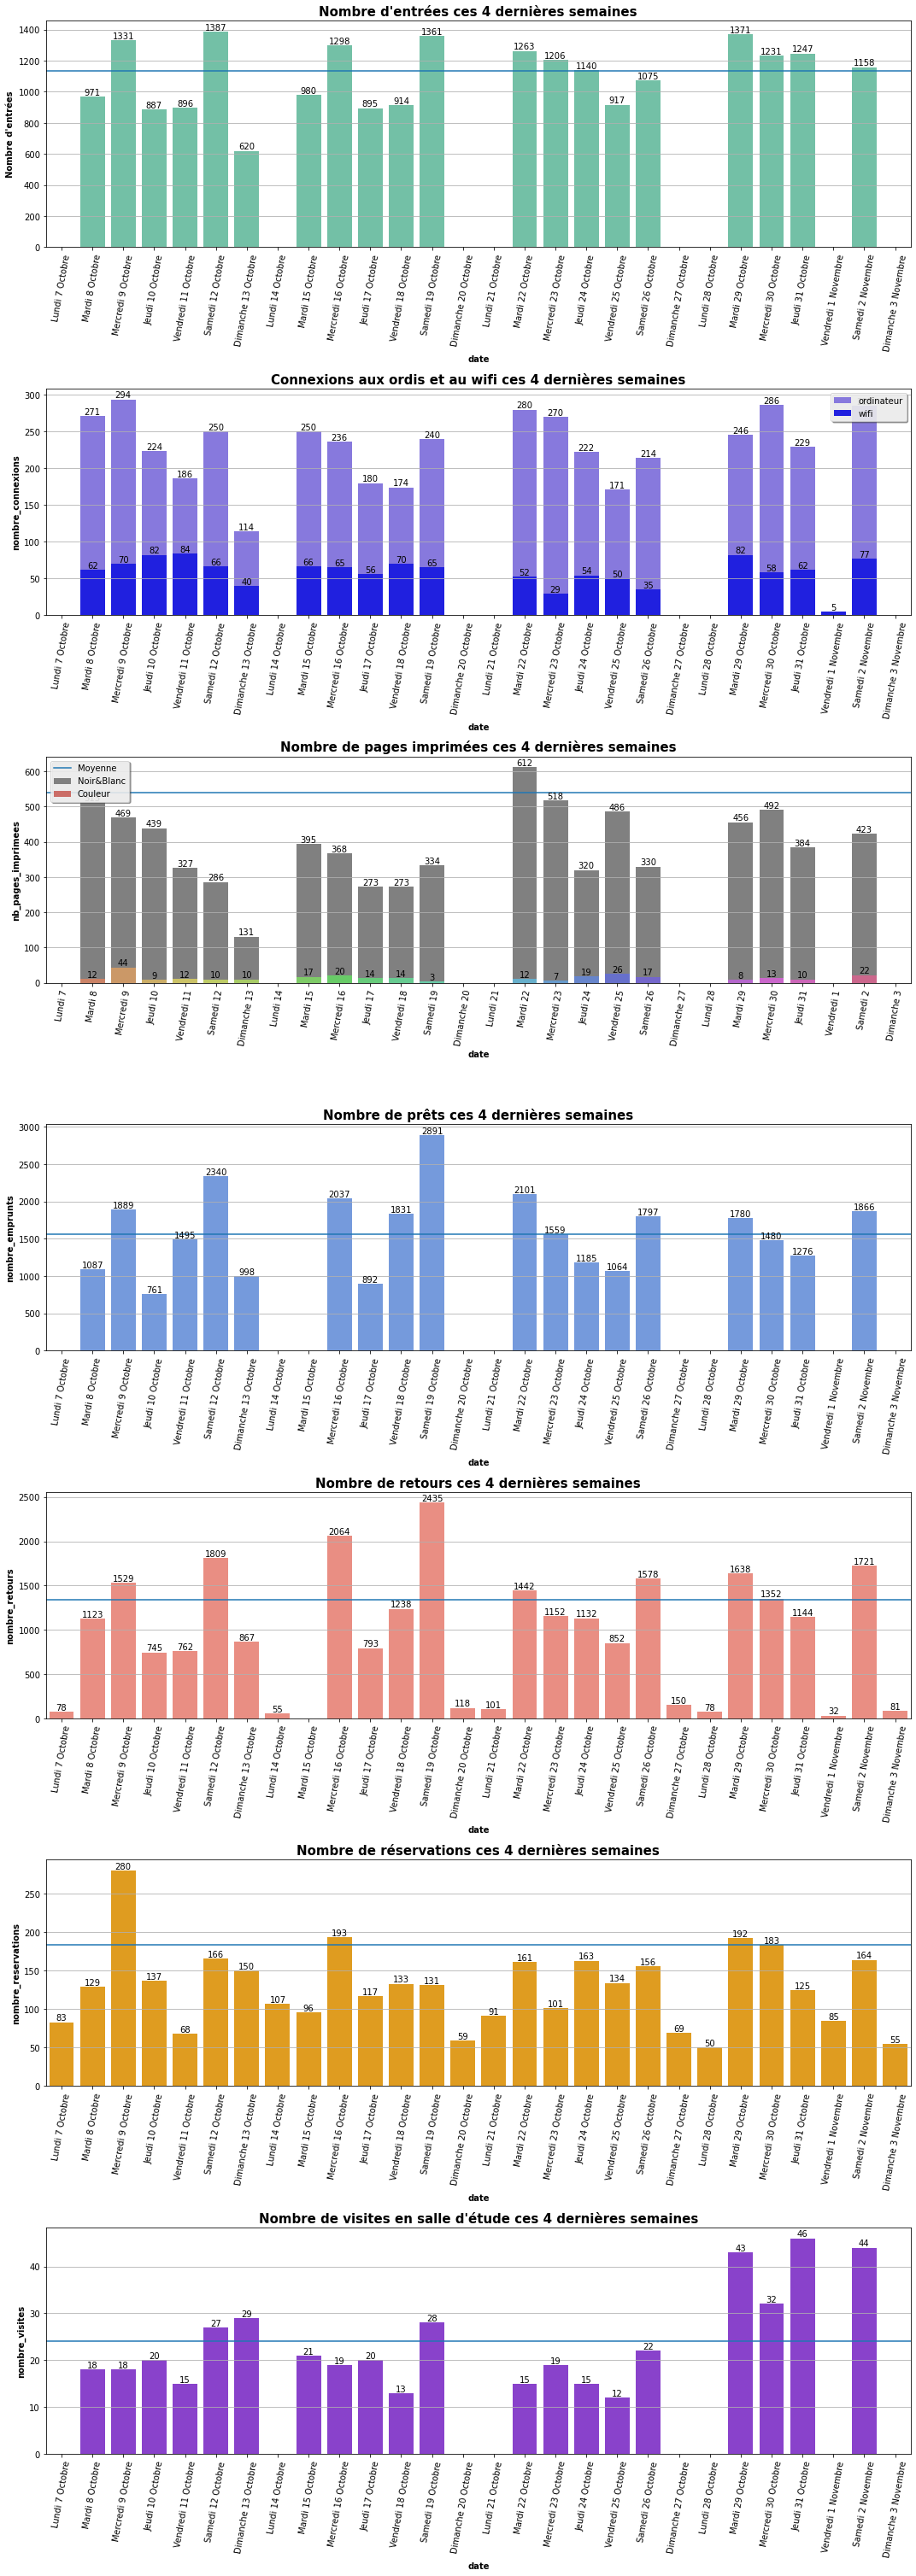

In [15]:
n = 7
h = n * 6
l = 15
params = {'axes.titlesize': 15,
          'axes.titleweight':'bold',
          'axes.grid':'y',
          'axes.labelweight':'bold',
          'legend.shadow':True,
          'figure.subplot.hspace': 0.7,
         }
plt.rcParams.update(params)
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=entrees_4lastweek,x='date',y='nombre_entrees',ax=ax[0],color='mediumaquamarine')
#ax[0] = sns.barplot(data=df_entrees,x='date',y='nombre_entrees',ax=ax[0],color='mediumaquamarine',palette=vacances)
ax[0].set_title("Nombre d'entrées ces 4 dernières semaines")
#ax[0].set_xlabel("jour de la semaine")
ax[0].set_ylabel("Nombre d'entrées")
ax[0].tick_params(axis='x',rotation=80,bottom=True)
ax[0].axhline(y=mean_entrees)
for i in ax[0].containers:
    ax[0].bar_label(i,)

ax[1] = sns.barplot(data=ordis_4lastweek,x="date",y='nombre_connexions',ax=ax[1],color='mediumslateblue',label="ordinateur")
ax[1] = sns.barplot(data=wifi_4lastweek,x="date",y='nombre_connexions',ax=ax[1],color='blue',label="wifi")
ax[1].set_title("Connexions aux ordis et au wifi ces 4 dernières semaines")
ax[1].tick_params(axis='x',rotation=80)                    
ax[1].legend()
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
ax[2] = sns.barplot(data=impressions_4lastweek_NoirBlanc,x="date",y='nb_pages_imprimees',ax=ax[2],color='gray',label="Noir&Blanc")
ax[2] = sns.barplot(data=impressions_4lastweek_Couleur,x="date",y='nb_pages_imprimees',ax=ax[2],palette='hls',label="Couleur")
ax[2].set_title("Nombre de pages imprimées ces 4 dernières semaines")
ax[2].tick_params(axis='x',rotation=80)                    
ax[2].axhline(y=mean_impressions,label='Moyenne')
ax[2].legend()
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
sns.barplot(data=prets_4lastweek,x='date',y='nombre_emprunts',ax=ax[3],label='prets',color='cornflowerblue')
ax[3].set_title('Nombre de prêts ces 4 dernières semaines')
ax[3].tick_params(axis='x',rotation=80)
ax[3].axhline(y=mean_prets)
for i in ax[3].containers:
    ax[3].bar_label(i,)

sns.barplot(data=retours_4lastweek,x='date',y='nombre_retours',ax=ax[4],label='retours',color='salmon')
ax[4].set_title('Nombre de retours ces 4 dernières semaines')
ax[4].tick_params(axis='x',rotation=80)
ax[4].axhline(y=mean_retours,label='Moyenne')
for i in ax[4].containers:
    ax[4].bar_label(i,)
    
sns.barplot(data=reservations_4lastweek,x='date',y='nombre_reservations',ax=ax[5],color='orange')
ax[5].set_title("Nombre de réservations ces 4 dernières semaines")
ax[5].tick_params(axis='x',rotation=80)
ax[5].axhline(y=mean_reservations)
for i in ax[5].containers:
    ax[5].bar_label(i,)

sns.barplot(data=visites_4lastweek,x='date',y='nombre_visites',ax=ax[6],color='blueviolet')
ax[6].set_title("Nombre de visites en salle d'étude ces 4 dernières semaines")
ax[6].tick_params(axis='x',rotation=80)
ax[6].axhline(y=mean_visites)
for i in ax[6].containers:
    ax[6].bar_label(i,)

f.tight_layout()

# Chiffres sur les 4 dernières semaines

In [16]:
bold = '\033[1m'
end = '\033[0m'

In [17]:
print(f"{bold}{total_entrees}{end} entrées avec en moyenne {bold}{mean_entrees}{end} entrées par jour")
print(f"{bold}{total_ordis}{end} connexions aux ordinateurs pour {bold}{distinct_ordis}{end} utilisateurs distinct avec en moyenne {bold}{mean_ordis}{end} connexions par jour")
print(f"{bold}{total_wifi}{end} connexions au wifi pour {bold}{distinct_wifi}{end} utilisateurs distincts avec en moyenne {bold}{mean_wifi}{end} connexions par jour")
print(f"{bold}{total_impressions}{end} impressions pour {bold}{distinct_impressions}{end} personnes distincts avec en moyenne {bold}{mean_impressions}{end} impressions par jour")
print(f"{bold}{total_prets}{end} prêts pour {bold}{distinct_prets}{end} emprunteur.ses distinct.es avec en moyenne {bold}{mean_prets}{end} prets par jour")
print(f"{bold}{total_retours}{end} retours avec en moyenne {bold}{mean_retours}{end} retours par jour")
print(f"{bold}{total_reservations}{end} réservations pour {bold}{distinct_resas}{end} réserveur.ses avec en moyenne {bold}{mean_reservations}{end} réservations par jour")
print(f"{bold}{total_visites}{end} visites en salle d'étude avec en moyenne {bold}{mean_visites}{end} visites par jour")

22148 entrées avec en moyenne 1136 entrées par jour
4622 connexions aux ordinateurs pour 1693 utilisateurs distinct avec en moyenne 237 connexions par jour
1230 connexions au wifi pour 467 utilisateurs distincts avec en moyenne 63 connexions par jour
10533 impressions pour 1990 personnes distincts avec en moyenne 540 impressions par jour
30329 prêts pour 4585 emprunteur.ses distinct.es avec en moyenne 1555 prets par jour
26069 retours avec en moyenne 1337 retours par jour
3578 réservations pour 1168 réserveur.ses avec en moyenne 183 réservations par jour
476 visites en salle d'étude avec en moyenne 24 visites par jour


> **La moyenne est calculée sur la base du nombre de jours ouverts** (soit le nombre de jours où la médiathèque enregistre au moins une entrée. Si le jour est compris entre mardi et samedi on compte 1 et si le jour est un dimanche on compte une demi-journée soit 0.5 jour)

> **Exception ! Pour les réservations et les retours** puisque le service est techniquement disponible 7/7jours